# **MENTAL HEALTH ANALYSIS**

### **STAKEHOLDER** - Healthcare Professionals
### **BUSINESS QUESTION** - Who is likely to seek mental health treatment?
### **TARGET VARIABLE** - Treatment (Treatment has a highly balanced class, yes and no are uniformly distributed)
### **OTHER COLUMNS** - Timestamp, Gender,	Country	Occupation,	self_employed,	family_history, Days_Indoors,	Growing_Stress,	Changes_Habits,	Mental_Health_History,	Mood_Swings,	Coping_Struggles,	Work_Interest,	Social_Weakness,mental_health_interview,	care_options

## **1. REQUIRED INSTALLATION**

In [1]:
!pip install catboost
!pip install -q findspark

## **2. IMPORT LIBRARIES**

In [2]:
import os
import time
from pyspark.sql import SparkSession
from sklearn.linear_model import LogisticRegression
from pyspark.sql.functions import isnull, col, sum, count, when
import pandas as pd
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
from scipy.stats import chi2_contingency
import pickle
import findspark


## **3. SET UP SPARK**

In [3]:
# Set Spark version and Java environment variables
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz

# Start a SparkSession
findspark.init()
spark = SparkSession.builder.appName("Mental Health Analysis").getOrCreate()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 261 kB in 2s (120 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## **4. IMPORT DATA FROM KAGGLE**

In [4]:
from google.colab import userdata
os.environ['KAGGLE_USERNAME'] = userdata.get('USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KEY')
# Download your dataset
!kaggle datasets download -d divaniazzahra/mental-health-dataset
!unzip /content/mental-health-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/divaniazzahra/mental-health-dataset
License(s): MIT
mental-health-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/mental-health-dataset.zip
replace Mental Health Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Mental Health Dataset.csv  


## **5. EXTRACT TRANSFORM AND LOAD (ETL)**

### Data Preprocessing
### *Read data into spark*

In [5]:
csv_path = "Mental Health Dataset.csv"
spark_df = spark.read.csv(csv_path, header=True, inferSchema=True)

### *Convert Spark Dataframe to Pandas Dataframe*

In [6]:
mental_health = spark_df.toPandas()
mental_health.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,2014-08-27 11:29:31,Female,United States,Corporate,None,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,2014-08-27 11:31:50,Female,United States,Corporate,None,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,2014-08-27 11:32:39,Female,United States,Corporate,None,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,2014-08-27 11:37:59,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,2014-08-27 11:43:36,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


### *Create a copy of Pandas Dataframe*

In [7]:
# Copy for preprocessing
mental_health_df = mental_health.copy()
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Timestamp                292364 non-null  datetime64[ns]
 1   Gender                   292364 non-null  object        
 2   Country                  292364 non-null  object        
 3   Occupation               292364 non-null  object        
 4   self_employed            287162 non-null  object        
 5   family_history           292364 non-null  object        
 6   treatment                292364 non-null  object        
 7   Days_Indoors             292364 non-null  object        
 8   Growing_Stress           292364 non-null  object        
 9   Changes_Habits           292364 non-null  object        
 10  Mental_Health_History    292364 non-null  object        
 11  Mood_Swings              292364 non-null  object        
 12  Coping_Struggles

### *Check for columns with null rows.*

In [8]:
# Check for nulls
mental_health_df.isnull().sum()

,0
Timestamp,0
Gender,0
Country,0
Occupation,0
self_employed,5202
family_history,0
treatment,0
Days_Indoors,0
Growing_Stress,0
Changes_Habits,0


### *Drop null rows*

In [9]:
# Drop nulls
mental_health_df.dropna(inplace=True)

### *Verify whether nulls are dropped properly.*

In [10]:
# Verify nulls are dropped
mental_health_df.isnull().sum()

,0
Timestamp,0
Gender,0
Country,0
Occupation,0
self_employed,0
family_history,0
treatment,0
Days_Indoors,0
Growing_Stress,0
Changes_Habits,0


### *Check for duplicated rows*

In [11]:
mental_health_df.duplicated().sum()

np.int64(354)

### *Drop duplicated rows.*

In [12]:
# Drop duplicates
mental_health_df_cleaned=mental_health_df.drop_duplicates()

### *Verify there are no duplicated rows*

In [13]:
mental_health_df_cleaned.duplicated().sum()

np.int64(0)

### *Check unique values in Timestamp*

In [14]:

# 1. Convert the 'Timestamp' column to datetime objects
mental_health_df['Timestamp'] = pd.to_datetime(mental_health_df_cleaned['Timestamp'])

# 2. Create a new column with month-year combination
mental_health_df_cleaned['Month_Year'] = mental_health_df_cleaned['Timestamp'].dt.to_period('M')


# 3. Get unique months-year  combination
unique_months_years = mental_health_df_cleaned['Month_Year'].unique()


# 4. Print the results
print("Unique Month-Year Combination:", unique_months_years)

Unique Month-Year Combination: <PeriodArray>
['2014-08', '2014-09', '2014-10', '2014-12', '2015-02', '2015-06', '2014-11',
 '2015-04', '2015-05', '2015-07', '2015-08', '2015-09', '2016-02']
Length: 13, dtype: period[M]


<ipython-input-14-9883d02237c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned['Month_Year'] = mental_health_df_cleaned['Timestamp'].dt.to_period('M')


Data unavailable for all months of the year. This leads to biasing. Therefore, droped 'Timestamp' column.

### *Drop Timestamp column*

In [15]:
# Drop Timestamp
mental_health_df_cleaned.drop(['Month_Year','Timestamp'], axis=1, inplace=True)

<ipython-input-15-ec40efc6a9ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned.drop(['Month_Year','Timestamp'], axis=1, inplace=True)


### *Group rare countries(< 1000 counts) together into 'Other'*

In [16]:
# Number of distinct countries
distinct_country_count = mental_health_df_cleaned['Country'].nunique()
print(f"Number of distinct countries: {distinct_country_count}")

# Count of rows per country
country_counts = mental_health_df_cleaned['Country'].value_counts()

# Filter countries with at least 1000 entries
popular_countries = country_counts[country_counts >= 1000].index.tolist()

# Replace less frequent countries with 'Other'
mental_health_df_cleaned['Country'] = mental_health_df_cleaned['Country'].apply(lambda x: x if x in popular_countries else 'Other')
mental_health_df_cleaned['Country'].value_counts()

Number of distinct countries: 35


<ipython-input-16-eb4322a2511f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df_cleaned['Country'] = mental_health_df_cleaned['Country'].apply(lambda x: x if x in popular_countries else 'Other')


,count
Country,
United States,167819
United Kingdom,50576
Canada,17529
Other,9832
Australia,6014
Netherlands,5891
Ireland,5542
Germany,4680
Sweden,2812


### *Summarizing the dataset*

In [17]:
# Print a summary of the dataset
print(f"Total number of rows before preprocessing: {mental_health.shape}")
print(f"Total number of rows after preprocessing: {mental_health_df_cleaned.shape}")
print("\nData Info:")
mental_health_df_cleaned.reset_index().info()


Total number of rows before preprocessing: (292364, 17)
Total number of rows after preprocessing: (286808, 16)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286808 entries, 0 to 286807
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   index                    286808 non-null  int64 
 1   Gender                   286808 non-null  object
 2   Country                  286808 non-null  object
 3   Occupation               286808 non-null  object
 4   self_employed            286808 non-null  object
 5   family_history           286808 non-null  object
 6   treatment                286808 non-null  object
 7   Days_Indoors             286808 non-null  object
 8   Growing_Stress           286808 non-null  object
 9   Changes_Habits           286808 non-null  object
 10  Mental_Health_History    286808 non-null  object
 11  Mood_Swings              286808 non-null  object
 12  Copin

In [18]:
print(f"Cleaned DataFrame:")
mental_health_df_cleaned.head()

Cleaned DataFrame:


,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
3,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
5,Female,Other,Corporate,No,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Not sure
6,Female,Australia,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
7,Female,United States,Corporate,No,No,No,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No


# **6. EXPLORATORY DATA ANALYSIS (EDA)**

# *Analyzing 'treatment's' frequency distribution.*

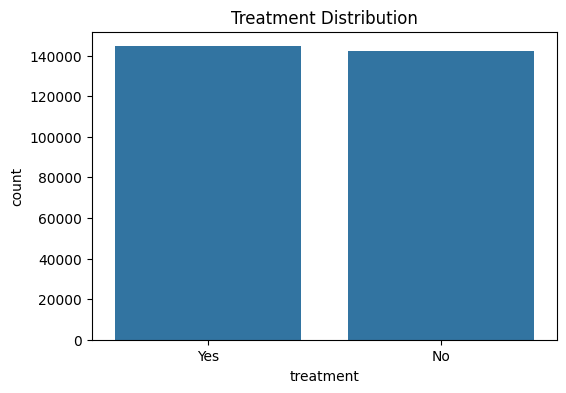

In [19]:
# Target Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='treatment', data = mental_health_df_cleaned)
plt.title('Treatment Distribution')
plt.show()

#### Analyses - There is no imbalance in class(Yes/No) distribution. Therefore, treatment can be used as a target variable.

### *Categorical Analysis*

<ipython-input-20-9149e0592d6c>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
<ipython-input-20-9149e0592d6c>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
<ipython-input-20-9149e0592d6c>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
<ipython-input-20-9149e0592d6c>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
<ipy

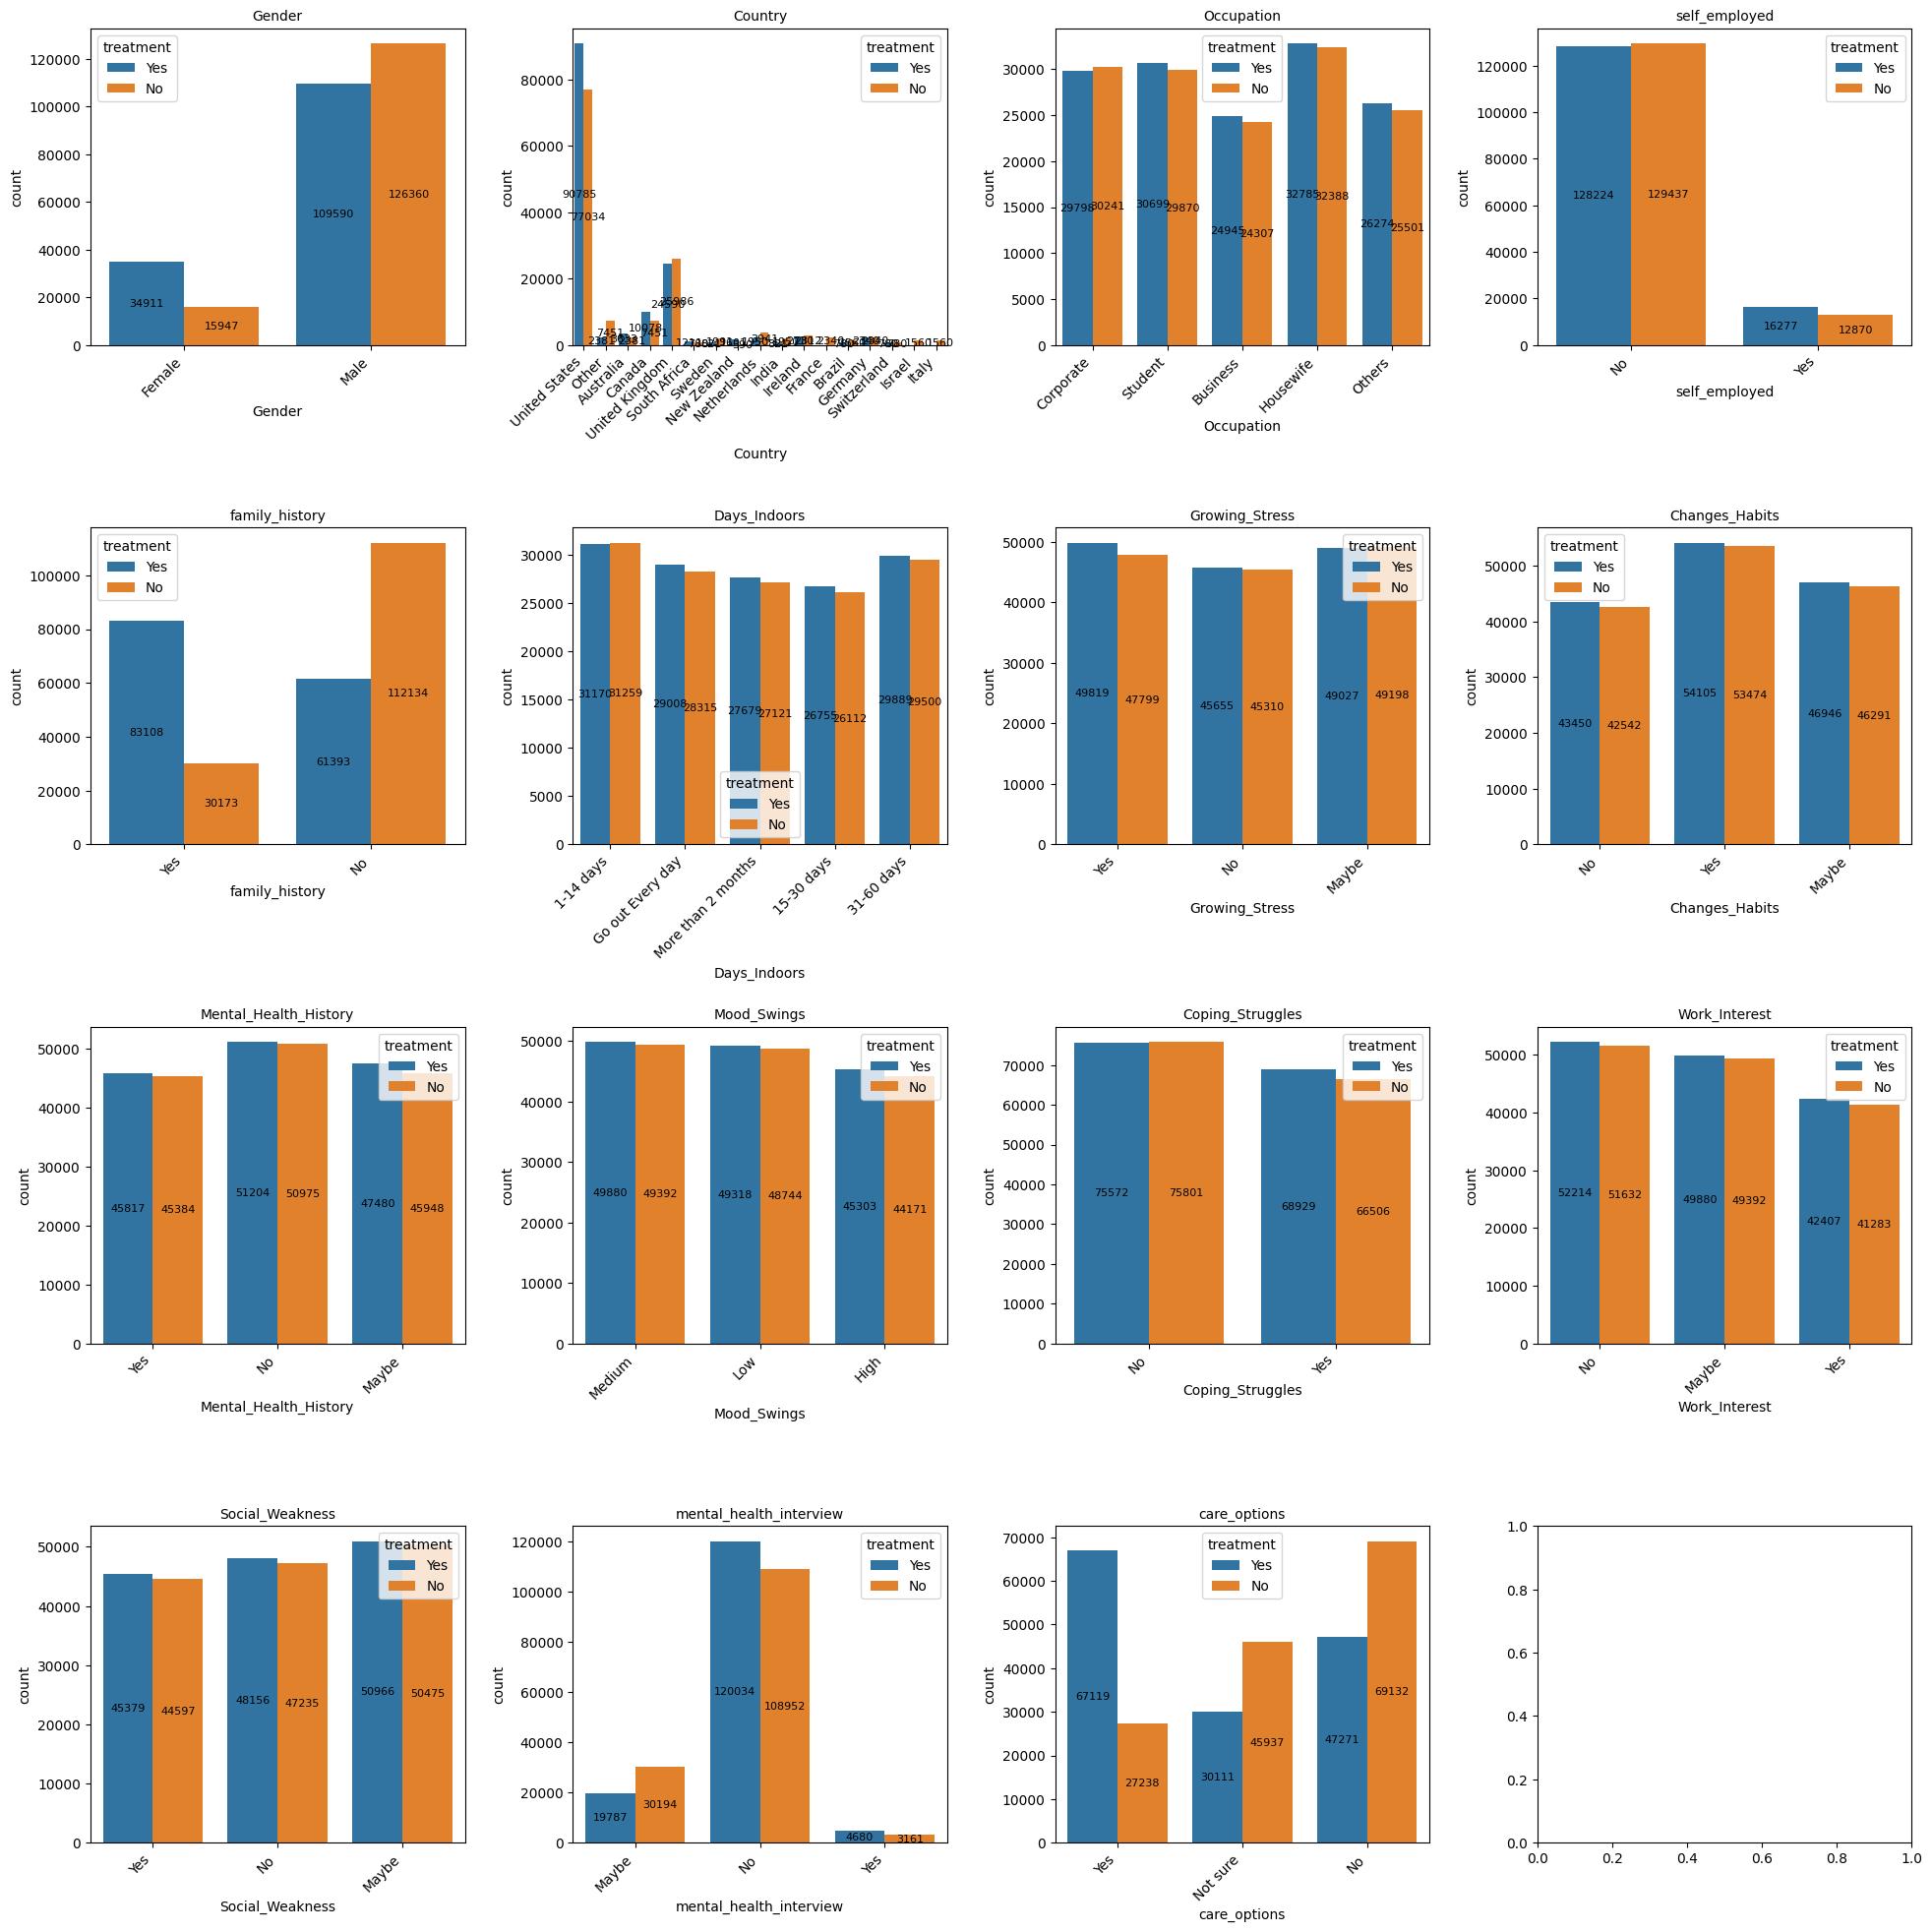

In [20]:
# Define categorical columns
categorical_columns = ['Gender', 'Country', 'Occupation', 'self_employed', 'family_history',
                       'Days_Indoors', 'Growing_Stress', 'Changes_Habits', 'Mental_Health_History',
                       'Mood_Swings', 'Coping_Struggles', 'Work_Interest', 'Social_Weakness',
                       'mental_health_interview', 'care_options']

# Create subplot
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

# Function to plot and customize countplot
def plot_countplot(ax, col_name, data):
    sns.countplot(x=col_name, hue = 'treatment', data=data, ax=ax)
    ax.set_title(col_name, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fontsize=8)

# Iterate and plot for each categorical column
for indx, col_name in enumerate(categorical_columns):
    plot_countplot(axes[indx], col_name, mental_health_df_cleaned)

# Adjust layout and display plot
plt.tight_layout(pad=2.0)
plt.show()

# **6. SPLITTING AND TRAINING**

In [21]:
# Create feature variables and target variable
X =mental_health_df_cleaned.drop('treatment', axis =1)
y = mental_health_df_cleaned['treatment']
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
# Create Pool for catboost modeling
cat_features = X.columns.to_list()
train_pool = Pool(X_train, y_train, cat_features = cat_features)
test_pool = Pool(X_test, y_test, cat_features = cat_features)

# **7. MODELING AND EVALUATING PERFORMANCE METRICS**

### **A) Modeling using 15 features. Algorithm used - CATBOOST**


#### Defining a function to split, train, evaluate performance metrics and save the model

In [22]:
# Define a function to train and evaluate a CatBoost model, with customizable parameters and model saving
def models(iteration, depth, learning_rate, verbose, random_state, stopping_round, model_name=None):
    # Check if a model_name is provided; if not, generate a default name using the current timestamp
    if model_name is None:
        # Create a default filename with the format 'catboost_model_<timestamp>'
        model_name = f'catboost_model_{int(time.time())}'
    # Ensure the model_name ends with '.pkl' for consistency in file extensions
    if not model_name.endswith('.pkl'):
        # Append '.pkl' to the model_name if it doesn't already have the extension
        model_name += '.pkl'
  ## Initialize a CatBoostClassifier model with specified hyperparameters
    model = CatBoostClassifier(iterations = iteration, # Number of boosting iterations (trees) to train
                                      depth = depth, # Maximum depth of each tree
                                      learning_rate = learning_rate, # Step size for gradient updates during training
                                      loss_function = 'Logloss',  # Loss function to optimize (Logloss for binary classification)
                                      verbose = verbose, # Controls the verbosity of training output
                                      random_state = random_state, # Seed for reproducibility of random processes
                                )
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds= stopping_round)
    # Predict and evaluate initial model
    y_prediction = model.predict(test_pool)
    print(f"\n CatBoost Model's performance with:\n iterations = {iteration}\n depth = {depth}\n learning_rate ={learning_rate}\n verbose = {verbose},\n random_state = {random_state},\n stopping_round = {stopping_round}\n")
    print("----------------------------------\n")
    print(f"Accuracy : {accuracy_score(y_test,y_prediction)} ")
    print("----------------------------------\n")
    print(f"Classification Report : \n {classification_report(y_test, y_prediction)}")
    # Save the model with the specified name
    pickle.dump(model, open(model_name, 'wb'))
    print("----------------------------------\n")
    print(f"Model saved as {model_name}")
    return model

### **DELIVERABLE 1**

In [23]:
fifteen_features_model_opt1 = models(500, 6,0.1, 0, 42, 50, 'fifteen_features_model_opt1.pkl')


 CatBoost Model's performance with:
 iterations = 500
 depth = 6
 learning_rate =0.1
 verbose = 0,
 random_state = 42,
 stopping_round = 50

----------------------------------

Accuracy : 0.7860255918552351 
----------------------------------

Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.72      0.77     28252
         Yes       0.76      0.85      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.79      0.78     57362
weighted avg       0.79      0.79      0.79     57362

----------------------------------

Model saved as fifteen_features_model_opt1.pkl


### **DELIVERABLE 2**

In [24]:
fifteen_features_model_opt2 = models(649, 8,0.05, 0, 42, 100, 'fifteen_features_model_opt2.pkl')


 CatBoost Model's performance with:
 iterations = 649
 depth = 8
 learning_rate =0.05
 verbose = 0,
 random_state = 42,
 stopping_round = 100

----------------------------------

Accuracy : 0.7859907255674489 
----------------------------------

Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.72      0.77     28252
         Yes       0.76      0.85      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.79      0.78     57362
weighted avg       0.79      0.79      0.79     57362

----------------------------------

Model saved as fifteen_features_model_opt2.pkl


### **B) Modeling using 15 features. Algorithm used - LOGISTIC REGRESSION**

In [25]:
# Logistic regression needs encoding
# Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train.astype(str))
X_test_encoded = encoder.transform(X_test.astype(str))

# Encode the target (Yes/No)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize Logistic Regression classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=0)

# Train the model
classifier.fit(X_train_encoded, y_train_encoded)

# Print training and testing scores
print(f"Training Data Score: {classifier.score(X_train_encoded, y_train_encoded)}")
print(f"Testing Data Score: {classifier.score(X_test_encoded, y_test_encoded)}")

# Make predictions
predictions_encoded = classifier.predict(X_test_encoded)
predictions = label_encoder.inverse_transform(predictions_encoded)

# Create a DataFrame to compare predictions and actual values
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
print("\nPrediction Results (First 10 Rows):")
print(results.head(10))

# Display accuracy score
print(f"\nAccuracy Score: {accuracy_score(y_test, predictions)}")

# Save the model
pickle.dump(classifier, open('logistic_regression_model.pkl', 'wb'))
print("Model saved as logistic_regression_model.pkl")

Training Data Score: 0.7091036670937824
Testing Data Score: 0.71306788466232

Prediction Results (First 10 Rows):
  Prediction Actual
0         No     No
1        Yes     No
2         No    Yes
3         No     No
4        Yes     No
5         No     No
6        Yes     No
7        Yes    Yes
8         No     No
9         No     No

Accuracy Score: 0.71306788466232
Model saved as logistic_regression_model.pkl


### **C) Modeling using 15 features. Algorithm used - MLP**

In [26]:
# Initialize MLP Classifier
classifier = MLPClassifier(hidden_layer_sizes=(64, 32),
                          activation='relu',
                          solver='adam',
                          max_iter=200,
                          random_state=0)

# Train the model
classifier.fit(X_train_encoded, y_train_encoded)

# Print training and testing scores
print(f"Training Data Score: {classifier.score(X_train_encoded, y_train_encoded)}")
print(f"Testing Data Score: {classifier.score(X_test_encoded, y_test_encoded)}")

# Make predictions
predictions_encoded = classifier.predict(X_test_encoded)
predictions = label_encoder.inverse_transform(predictions_encoded)

# Create a DataFrame to compare predictions and actual values
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
print("\nPrediction Results (First 10 Rows):")
print(results.head(10))

# Display accuracy score
print(f"\nAccuracy Score: {accuracy_score(y_test, predictions)}")

# Save the model
pickle.dump(classifier, open('mlp_model.pkl', 'wb'))
print("Model saved as mlp_model.pkl")

Training Data Score: 0.781970485430123
Testing Data Score: 0.7835500854224051

Prediction Results (First 10 Rows):
  Prediction Actual
0         No     No
1         No     No
2        Yes    Yes
3         No     No
4        Yes     No
5         No     No
6        Yes     No
7        Yes    Yes
8        Yes     No
9         No     No

Accuracy Score: 0.7835500854224051
Model saved as mlp_model.pkl


# **8. FEATURE IMPORTANCE ON CATBOOST MODEL**

In [27]:
# Get feature importance
feature_importance = fifteen_features_model_opt1.get_feature_importance(prettified=True)
print("\nFeature Importance :")
print(feature_importance)


Feature Importance :
                 Feature Id  Importances
0                   Country    25.765610
1              care_options    23.762813
2   mental_health_interview    14.205505
3            family_history    13.960962
4             self_employed    12.679121
5                    Gender     8.858460
6            Growing_Stress     0.124753
7     Mental_Health_History     0.114128
8               Mood_Swings     0.109733
9                Occupation     0.104349
10          Social_Weakness     0.086439
11             Days_Indoors     0.086400
12            Work_Interest     0.077687
13           Changes_Habits     0.060331
14         Coping_Struggles     0.003709


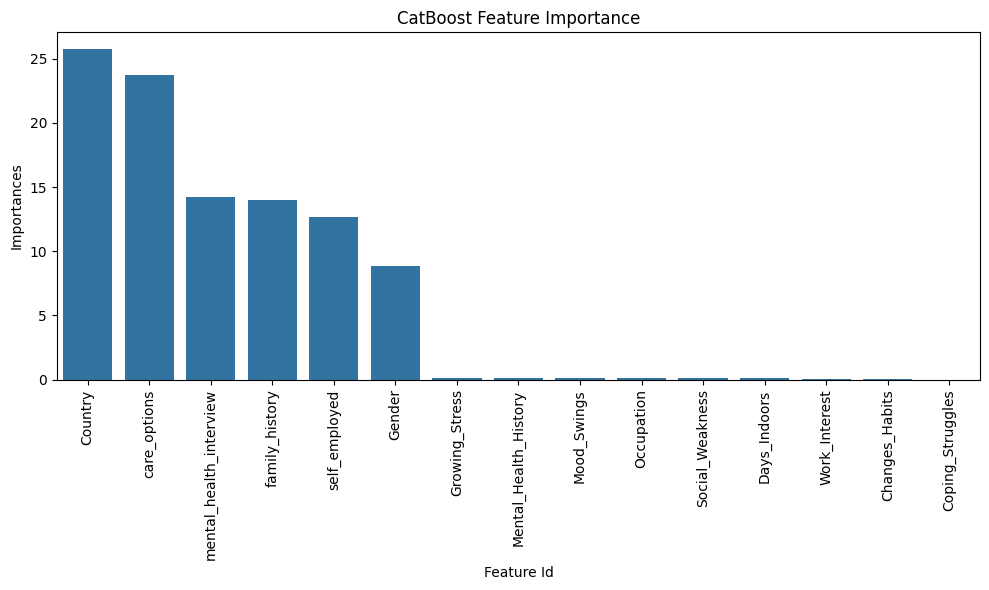

In [28]:
# Visualizing the feature importance
plt.figure(figsize=(10,6))
sns.barplot(x="Feature Id", y="Importances", data=feature_importance)
plt.xticks(rotation=90)
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

# **9. CORRELATION ANALYSIS**


Pairwise Cramér’s V Correlation Matrix:
                           Gender   Country  Occupation  self_employed  \
Gender                   0.999988  0.150033    0.049315       0.064985   
Country                  0.150033  1.000000    0.003699       0.236055   
Occupation               0.049315  0.003699    1.000000       0.003206   
self_employed            0.064985  0.236055    0.003206       0.999981   
family_history           0.196321  0.191824    0.009682       0.011195   
Days_Indoors             0.030699  0.002303    0.069072       0.001995   
Growing_Stress           0.056818  0.006028    0.078526       0.003693   
Changes_Habits           0.011585  0.001229    0.065681       0.000753   
Mental_Health_History    0.036368  0.003858    0.074247       0.002364   
Mood_Swings              0.019995  0.002121    0.135105       0.001300   
Coping_Struggles         0.057117  0.008571    0.079852       0.003702   
Work_Interest            0.021950  0.002329    0.057157       0.001427 

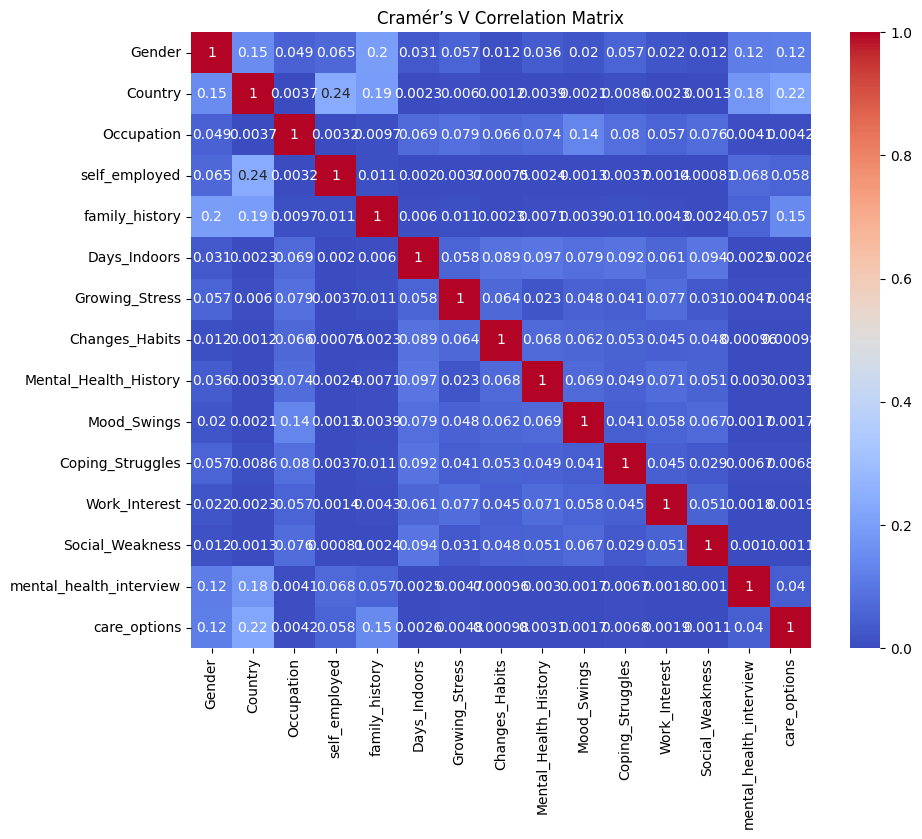


Feature-Target Cramér’s V Correlations:
                         Cramér’s V with Treatment
family_history                            0.371379
care_options                              0.290716
Country                                   0.209506
Gender                                    0.169562
mental_health_interview                   0.101948
self_employed                             0.036731
Coping_Struggles                          0.009680
Growing_Stress                            0.009635
Occupation                                0.008362
Mental_Health_History                     0.006167
Days_Indoors                              0.005206
Work_Interest                             0.003722
Mood_Swings                               0.003391
Social_Weakness                           0.002114
Changes_Habits                            0.001964

Highly Correlated Feature Pairs (Cramér’s V >= 0.1):
[]

Features to Drop due to High Correlation: []


In [29]:
# Correlation Analysis with Cramér’s V
# Function to calculate Cramér’s V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Compute pairwise correlations between features
features = mental_health_df_cleaned.drop('treatment', axis=1).columns
corr_matrix = pd.DataFrame(index=features, columns=features)
for f1 in features:
    for f2 in features:
        corr_matrix.loc[f1, f2] = cramers_v(mental_health_df_cleaned[f1], mental_health_df_cleaned[f2])

corr_matrix = corr_matrix.astype(float)
print("\nPairwise Cramér’s V Correlation Matrix:")
print(corr_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér’s V Correlation Matrix")
plt.show()

# Compute feature-target correlations
target_corrs = {}
for f in features:
    target_corrs[f] = cramers_v(mental_health_df_cleaned[f], mental_health_df_cleaned['treatment'])
target_corr_df = pd.DataFrame.from_dict(target_corrs, orient='index', columns=['Cramér’s V with Treatment'])
target_corr_df = target_corr_df.sort_values(by='Cramér’s V with Treatment', ascending=False)
print("\nFeature-Target Cramér’s V Correlations:")
print(target_corr_df)

# Identify highly correlated feature pairs (threshold: 0.8)
high_corr_pairs = []
threshold = 0.8
for i in range(len(features)):
    for j in range(i+1, len(features)):
        if corr_matrix.iloc[i, j] >= threshold:
            high_corr_pairs.append((features[i], features[j], corr_matrix.iloc[i, j]))
print("\nHighly Correlated Feature Pairs (Cramér’s V >= 0.1):")
print(high_corr_pairs)

# Drop one feature from each highly correlated pair (if any)
features_to_drop = []
for f1, f2, corr in high_corr_pairs:
    # Keep the feature with higher target correlation
    if target_corrs[f1] > target_corrs[f2]:
        features_to_drop.append(f2)
    else:
        features_to_drop.append(f1)
features_to_drop = list(set(features_to_drop))
print(f"\nFeatures to Drop due to High Correlation: {features_to_drop}")

# Update dataset
if features_to_drop:
    mental_health_df_cleaned = mental_health_df_cleaned.drop(columns=features_to_drop)
    print(f"Dataset Shape after Dropping Correlated Features: {mental_health_df_cleaned.shape}")

### **Modeling using 6 features. Algorithm used - CATBOOST**

In [30]:
top_six_features = feature_importance['Feature Id'].head(6).tolist()
print(f"Selected Top 6 features are : {top_six_features}")

Selected Top 6 features are : ['Country', 'care_options', 'mental_health_interview', 'family_history', 'self_employed', 'Gender']


In [31]:
# Filtered dataset
mental_health_df_cleaned_case = mental_health_df_cleaned[top_six_features+['treatment']].reset_index(drop=True)
mental_health_df_cleaned_case.head()

,Country,care_options,mental_health_interview,family_history,self_employed,Gender,treatment
0,United States,Yes,Maybe,Yes,No,Female,Yes
1,United States,Yes,No,Yes,No,Female,Yes
2,Other,Not sure,Maybe,No,No,Female,Yes
3,Australia,Not sure,No,Yes,No,Female,Yes
4,United States,No,No,No,No,Female,No


In [32]:
# Train test split (with 6 selected features)
X =mental_health_df_cleaned_case.drop('treatment', axis =1)
y = mental_health_df_cleaned_case['treatment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
# Final model training
cat_features = X.columns.to_list()
train_pool = Pool(X_train, y_train, cat_features = cat_features)
test_pool = Pool(X_test, y_test, cat_features = cat_features)

### **DELIVERABLE 3**

In [33]:
six_features_model_opt1 = models(500, 6,0.1, 0, 42, 50, 'six_features_model_opt1.pkl')


 CatBoost Model's performance with:
 iterations = 500
 depth = 6
 learning_rate =0.1
 verbose = 0,
 random_state = 42,
 stopping_round = 50

----------------------------------

Accuracy : 0.7859384261357694 
----------------------------------

Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.72      0.77     28252
         Yes       0.76      0.85      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.78      0.78     57362
weighted avg       0.79      0.79      0.78     57362

----------------------------------

Model saved as six_features_model_opt1.pkl


### **DELIVERABLE 4**

In [34]:
six_features_model_opt2 = models(649, 8,0.05, 0, 42, 100, 'six_features_model_opt2.pkl')


 CatBoost Model's performance with:
 iterations = 649
 depth = 8
 learning_rate =0.05
 verbose = 0,
 random_state = 42,
 stopping_round = 100

----------------------------------

Accuracy : 0.7852933998117221 
----------------------------------

Classification Report : 
               precision    recall  f1-score   support

          No       0.81      0.73      0.77     28252
         Yes       0.76      0.84      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.78      0.78     57362
weighted avg       0.79      0.79      0.78     57362

----------------------------------

Model saved as six_features_model_opt2.pkl


### **Modeling using 10 features. Algorithm used - CATBOOST**

In [35]:
top_ten_features = feature_importance['Feature Id'].head(10).tolist()
print(f"Selected Top 10 features are : {top_ten_features}")
# Filtered dataset
mental_health_df_cleaned_casetwo = mental_health_df_cleaned[top_ten_features+['treatment']].reset_index(drop=True)
mental_health_df_cleaned_casetwo.head()

Selected Top 10 features are : ['Country', 'care_options', 'mental_health_interview', 'family_history', 'self_employed', 'Gender', 'Growing_Stress', 'Mental_Health_History', 'Mood_Swings', 'Occupation']


,Country,care_options,mental_health_interview,family_history,self_employed,Gender,Growing_Stress,Mental_Health_History,Mood_Swings,Occupation,treatment
0,United States,Yes,Maybe,Yes,No,Female,Yes,Yes,Medium,Corporate,Yes
1,United States,Yes,No,Yes,No,Female,Yes,Yes,Medium,Corporate,Yes
2,Other,Not sure,Maybe,No,No,Female,Yes,Yes,Medium,Corporate,Yes
3,Australia,Not sure,No,Yes,No,Female,Yes,Yes,Medium,Corporate,Yes
4,United States,No,No,No,No,Female,Yes,Yes,Medium,Corporate,No


In [36]:
# Train test split (with 10 selected features)
X =mental_health_df_cleaned_casetwo.drop('treatment', axis =1)
y = mental_health_df_cleaned_casetwo['treatment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0)
# Final model training
cat_features = X.columns.to_list()
train_pool = Pool(X_train, y_train, cat_features = cat_features)
test_pool = Pool(X_test, y_test, cat_features = cat_features)

### **DELIVERABLE 5**

In [37]:
ten_features_model_opt2 = models(649, 8,0.05, 0, 42, 100, 'ten_features_model_opt2.pkl')


 CatBoost Model's performance with:
 iterations = 649
 depth = 8
 learning_rate =0.05
 verbose = 0,
 random_state = 42,
 stopping_round = 100

----------------------------------

Accuracy : 0.7859209929918761 
----------------------------------

Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.72      0.77     28252
         Yes       0.76      0.85      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.79      0.78     57362
weighted avg       0.79      0.79      0.79     57362

----------------------------------

Model saved as ten_features_model_opt2.pkl


### **OVERALL MODEL PERFORMANCE OF THE FINAL CATBOOST MODEL WITH 10 FEATURES**


 CatBoost Model's performance with:
 iterations = 500
 depth = 6
 learning_rate =0.1
 verbose = 0,
 random_state = 42,
 stopping_round = 50

----------------------------------

Accuracy : 0.7861301907185942 
----------------------------------

Classification Report : 
               precision    recall  f1-score   support

          No       0.82      0.72      0.77     28252
         Yes       0.76      0.85      0.80     29110

    accuracy                           0.79     57362
   macro avg       0.79      0.79      0.78     57362
weighted avg       0.79      0.79      0.79     57362

----------------------------------

Model saved as ten_features_model_opt1.pkl
----------------------------------------------
----------------------------------------------

Confusion Matrix:


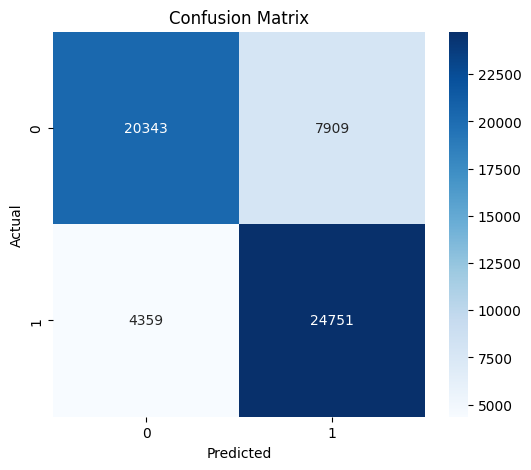


The model has been evaluated successfully and is ready for deployment in the cloud.


In [38]:
ten_features_model_opt1 = models(500, 6,0.1, 0, 42, 50, 'ten_features_model_opt1.pkl')
# Predict and evaluate initial model
y_prediction = ten_features_model_opt1.predict(test_pool)

print("----------------------------------------------")
# Print confuson matrix
conf_matrix = confusion_matrix(y_test, y_prediction)
conf_matrix
print("----------------------------------------------")

# Visualizing confusion matrix
print("\nConfusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nThe model has been evaluated successfully and is ready for deployment in the cloud.")


On analyzing all models, it is observed that reducing the dimensionality doesn't effect the accuracy. However, in order to reduce the effect of noise on the model, I have used catboost model with top 10 features for deploying in AWS.